# <center>***BEEP BOOP Agatha Christie?***</center> 
<center> <img src="https://static.vecteezy.com/system/resources/thumbnails/006/777/102/small_2x/the-mascot-of-cute-ballpoint-as-a-detective-vector.jpg" width=180 height=180 align="center"
 style="float:right;width:4px;height:4px;"></center>
<center>(Gutenberg Sequence-to-Sequence Generator)</center>


### <center>***By Trishla Jain***</center> 

This is the second notebook for our code and contains the Bidirectional LSTM which uses words rather than characters to train and predict.

Bidirectional LSTM's are used to train two sides of the input sequence i.e first from left to right of the input sequence and then in the reverse order or right to left of the input sequences. This provides one more context to the word to fit in the right context from words coming after and before, this results in a faster model and making the learning for the model effective.


In [ ]:
# importing all the necessary libraries for the notebook
import urllib
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pandas as pd
nltk.download('stopwords') # Let's try taking out the stopwords beforehand
nltk_stops = nltk.corpus.stopwords.words('english')
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# loading the books from Project Gutenberg

## Reading Book 1 - The Mysterious Affair at Styles, by Agatha Christie
# we saved the file to a .txt to remove the headers and footers from the file 
# i.e all the lines before and including -
# *** START OF THE PROJECT GUTENBERG EBOOK THE MYSTERIOUS AFFAIR AT STYLES ***
# and all the lines (after and including the below line)
# *** END OF THE PROJECT GUTENBERG EBOOK THE MYSTERIOUS AFFAIR AT STYLES ***

books_list  = ['../input/nlp-final-project-books/The Mysterious Affair at Styles.txt']


def read_lines(books):
    #creating a blank string to store the file text
    global book_text, book_text_lower;
    book_text = ''
    for book_name in books:
        file = open(book_name, 'r')
        for line in file:
            book_text += line
        file.close()
    book_text_lower = book_text.lower()
    return book_text, book_text_lower


read_lines(books_list)

('The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH OF JULY\nCHAPTER III. THE NIGHT OF THE TRAGEDY\nCHAPTER IV. POIROT INVESTIGATES\nCHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”\nCHAPTER VI. THE INQUEST\nCHAPTER VII. POIROT PAYS HIS DEBTS\nCHAPTER VIII. FRESH SUSPICIONS\nCHAPTER IX. DR. BAUERSTEIN\nCHAPTER X. THE ARREST\nCHAPTER XI. THE CASE FOR THE PROSECUTION\nCHAPTER XII. THE LAST LINK\nCHAPTER XIII. POIROT EXPLAINS\n\n\n\n\nCHAPTER I.\nI GO TO STYLES\n\n\nThe intense interest aroused in the public by what was known at the\ntime as “The Styles Case” has now somewhat subsided. Nevertheless, in\nview of the world-wide notoriety which attended it, I have been asked,\nboth by my friend Poirot and the family themselves, to write an account\nof the whole story. This, we trust, will effectually silence the\nsensational rumours which still persist.\n\nI will therefore briefly set down the circumstances which led to my

In [ ]:
books_list  = ['../input/nlp-final-project-books/The Mysterious Affair at Styles.txt',
              '../input/nlp-final-project-books/POIROT INVESTIGATES.txt',
              '../input/nlp-final-project-books/The Murder on the Links.txt']

read_lines(books_list)

("The Mysterious Affair at Styles\n\nby Agatha Christie\n\nContents\n\n\nCHAPTER I. I GO TO STYLES\nCHAPTER II. THE 16TH AND 17TH OF JULY\nCHAPTER III. THE NIGHT OF THE TRAGEDY\nCHAPTER IV. POIROT INVESTIGATES\nCHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”\nCHAPTER VI. THE INQUEST\nCHAPTER VII. POIROT PAYS HIS DEBTS\nCHAPTER VIII. FRESH SUSPICIONS\nCHAPTER IX. DR. BAUERSTEIN\nCHAPTER X. THE ARREST\nCHAPTER XI. THE CASE FOR THE PROSECUTION\nCHAPTER XII. THE LAST LINK\nCHAPTER XIII. POIROT EXPLAINS\n\n\n\n\nCHAPTER I.\nI GO TO STYLES\n\n\nThe intense interest aroused in the public by what was known at the\ntime as “The Styles Case” has now somewhat subsided. Nevertheless, in\nview of the world-wide notoriety which attended it, I have been asked,\nboth by my friend Poirot and the family themselves, to write an account\nof the whole story. This, we trust, will effectually silence the\nsensational rumours which still persist.\n\nI will therefore briefly set down the circumstances which led to my

In [ ]:
# Here the text that was made lower_case in the read_lines function and is split 
# based on new lines and then tokenized and post that we take a count of how 
# many such tokens get generated from the 3 books we fed as input to the model.

tokenizer = Tokenizer()

corpus = book_text_lower.split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(f"Total tokenized words are: {total_words}")


Total tokenized words are: 12295


A total of 12295 tokens were generated from our 3 books 

In [ ]:
list(tokenizer.word_index.items())[0:10]
# below we can see that 'the' corresponds to index 1, 'to' correponds to 3 and so on.

[('the', 1),
 ('”', 2),
 ('to', 3),
 ('i', 4),
 ('of', 5),
 ('a', 6),
 ('and', 7),
 ('was', 8),
 ('that', 9),
 ('it', 10)]

In [ ]:
# create input sequences using list of tokens
# For each word, an n-gram sequence is made and input sequences are updated. 
# It happens in the iteration for the next word and so on.
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences[0:6]

[[1, 689],
 [1, 689, 396],
 [1, 689, 396, 21],
 [1, 689, 396, 21, 384],
 [40, 2664],
 [40, 2664, 2665]]

As we can see above, the words got tokenized and were broken into sentences (split by new line) and got a numeric value for the model to learn. To further understand this, we will try to recreate what those indexes mean/check the sentence generated.

In [ ]:
list(tokenizer.word_index.items())[0], list(tokenizer.word_index.items())[688], list(tokenizer.word_index.items())[395], list(tokenizer.word_index.items())[20], list(tokenizer.word_index.items())[383]

(('the', 1), ('mysterious', 689), ('affair', 396), ('at', 21), ('styles', 384))

Below, we can see that value 1 correponds to index 0 in our dictionary which has the tokenized words.  Below is the representation of how the array/ n gram is created.

[[1, 689],

```
'The', 'mysterious'
```

 [1, 689, 396],
```
'The', 'mysterious', 'affair'
```

 [1, 689, 396, 21],
 ```
'The', 'mysterious', 'affair', 'at'
```

 [1, 689, 396, 21, 384],
 ```
'The', 'mysterious','affair', 'at', 'styles'
```


In [ ]:
list(tokenizer.word_index.items())[39],list(tokenizer.word_index.items())[2663],list(tokenizer.word_index.items())[2664]
# same way these index represents "by agatha christie"

(('by', 40), ('agatha', 2664), ('christie', 2665))

In [ ]:
# the maximum length is determined and that is used to pad
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
# converting the label to categorical form numerical
label = ku.to_categorical(label, num_classes=total_words)

Now, we will make a Sequential model with its first layer containing the word embeddings layer, then we used a bidirectional LSTM model where the parameter return_sequence is marked as True so that the word generation keeps the previous and the next words in the sequence in consideration.
A drop out layer has been added to avoid overfitting, then one more LSTM layer with 100 LSTM cells has been added.

Post that a Dense layer with ReLu activation has been added and a regularizer has been added, again to avoid overfitting.

Finally, there is a output layer with softmax activation, to get the probability of the word to be predicted next.


In [ ]:
model_6 = Sequential()
model_6.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_6.add(Bidirectional(LSTM(150, return_sequences = True)))
model_6.add(Dropout(0.2))
model_6.add(LSTM(100))
model_6.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dense(total_words, activation='softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_6.summary())

2022-05-11 04:50:54.163536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:50:54.305745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:50:54.306535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 04:50:54.307835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 100)           1229500   
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 18, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 6147)              620847    
_________________________________________________________________
dense_1 (Dense)              (None, 12295)             75589660  
Total params: 77,901,607
Trainable params: 77,901,607
Non-trainable params: 0
____________________________________________

In [ ]:
history_7 = model_6.fit(predictors, label, epochs=100, verbose=1)

2022-05-11 04:50:57.716810: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8018700640 exceeds 10% of free system memory.
2022-05-11 04:51:07.317701: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8018700640 exceeds 10% of free system memory.
2022-05-11 04:51:13.137056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-11 04:51:17.597277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5096/5096 [==============================] - 106s 20ms/step - loss: 6.4721 - accuracy: 0.0550
Epoch 2/100
5096/5096 [==============================] - 100s 20ms/step - loss: 6.0032 - accuracy: 0.0860
Epoch 3/100
5096/5096 [==============================] - 101s 20ms/step - loss: 5.7144 - accuracy: 0.1123
Epoch 4/100
5096/5096 [==============================] - 101s 20ms/step - loss: 5.5042 - accuracy: 0.1258
Epoch 5/100
5096/5096 [==============================] - 101s 20ms/step - loss: 5.3380 - accuracy: 0.1363
Epoch 6/100
5096/5096 [==============================] - 101s 20ms/step - loss: 5.2050 - accuracy: 0.1461
Epoch 7/100
5096/5096 [==============================] - 101s 20ms/step - loss: 5.0906 - accuracy: 0.1546
Epoch 8/100
5096/5096 [==============================] - 102s 20ms/step - loss: 4.9919 - accuracy: 0.1610
Epoch 9/100
5096/5096 [==============================] - 101s 20ms/step - loss: 4.9057 - accuracy: 0.1686
Epoch 10/100
5096/5096 [==============================] - 

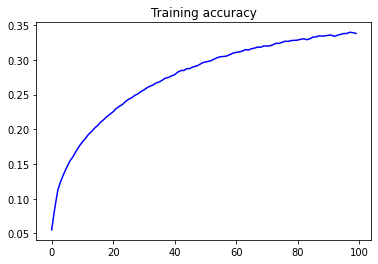

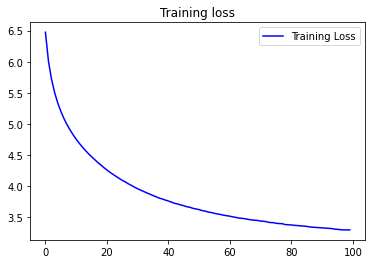

In [ ]:
import matplotlib.pyplot as plt
acc = history_7.history['accuracy']
loss = history_7.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

Our model, over 100 epochs, saw that the training accuracy increased and that the training loss decreased. This is great! We can see that the model didn't over fit so adding the dropout and kernel_regularizer was a good idea.

In [ ]:
seed_text = "The original dagger was" #randomly chosen seed
next_words = 1000

In [ ]:
print("\nBeginning text generation\n")

# Here the seed is taken at first and tokenized and padded on the token list.
# then the model is used to predict with the token list as input.

# Then most probable word is added to the seed text and this happens for 
# the next 1000 words
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # since predict-classes has depreciated we used predict function and then
    # used the word with the maximum probability by using argmax
    predict_x = model_6.predict(token_list)
    predicted = np.argmax(predict_x, axis=1)
    #predicted = model_6.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)
print("\nText Generation Done!\n")



Beginning text generation

The original dagger was a little annoyed is it ” i asked presently i had been here i am not sure of promising and remove the facts of these days ” i said slowly “it is possible that it is true that is a moment ” i said with a moment “the man was lying and a little annoyed was a little over the villa marguerite and a little idea of a small square ago and then she was in a few minutes for a moment or two i was in england she had been in the village to give herself to be a little idea that these one has been able to give me to be a little idea that you will see whether i ought to have been able to be able to give us anywhere to do with the crime ” i said with a moment lay a moment in a few minutes and then added a few questions i give her medicine at the same time i was not in the villa marguerite and unsatisfactory it is a little idea that you would have been here in the village to give her medicine but in the house ” i asked at length with a few minutes and b

**For better readability below is the one pager text generated by our model:**


"The original dagger was aroused on the war later when the prime minister had been in south america he was not strong enough the same man bore out a few moments the prime minister fell on his hand and a man of astonishment lay the stairs the sun route out in the house in a moment and then the whole story was broken in admirable paper and twenty years and then had a pity of paper in the house the war of the villa torch in the house and the circumstances of the war were in fact she would have remembered the same theatrical remarkable lodge of the villa and we were sitting at the house and the following morning he was not in the villa later i had a violent quarrel which had been able to go back from the villa chair and then was the same time carefully in a moment he had been in the house and we had a great idea that it was not the same time ” he replied with a few days travelling and indignantly fell into the room he worried me by the house and the following morning the man was not a marked silence i was absent from a few minutes he was safely sitting at the room he was safely apparently so excited in up the house which had been committed and i was deeply against each other night and it was child’s play for it ” said poirot thoughtfully “that is what he said ” he said at last “i am sure of it ” i asked with a few minutes and then he was sitting at the room and in the house ” cried poirot “that is it ” he said at last “i am convinced that i have been in the house now ” i said with a few minutes and then he was sitting at the door of the villa and the man was in the house and a touch of anger and above some way to the house and we were thinking of anger with a few moments he had intended to do oil kings of the ring down and water to london ” he said at the inquest poirot had been in the house and the man was not a little fogged as you have seen it to be a little unfair in law ’ and we all known to see him in the villa marguerite ” he said with a few minutes and her mother with his own hand was very careful that he would have been a little idea but to see him in the house ” he said at the inquest poirot had been in the house at the villa geneviève and the same will is a few moments and he spoke in a moment and then added softly over the house and we were sitting at the house the tragedy is not outside the tragedy ” he said with a few minutes and her mother with his own hand suddenly he spoke to me and then the circumstances of his mother was in the villa geneviève a moment of some kind he was not a little lecture of anger and then the medical evidence was in the house the prime minister was in the villa marguerite john looked down and then his own death he had been able to go to the villa geneviève and it was a few minutes and her mother in his own death ” said poirot with a few minutes and then the commissary burst into the open metropolitan as a man who had been in the house and the same will was a few minutes he was employed on the house and then the sun seized with july which he had been able to give us back from the same symptoms ” i said with a few brief words and her husband anywhere is very well utterly utterly veronal ” he said impatiently “we will tell you why are you sure ” said poirot with a few minutes and then he was standing at the villa geneviève a moment and the plates and dishes was getting aback he was not in the villa marguerite and we had a violent quarrel of london was a few moments the prime minister had been able to have been the same time and the man who had been in the house and cigarette end which could have taken place in a moment and then dorcas offered her by miss howard the circumstances was not in law that he was not in law in method i am asking you to do with it ” said poirot thoughtfully as he spoke he spoke and then he was a little annoyed but he would have been a great idea that it was not the same time ” he said at the other side hand which had been ground back to the villa and a few moments he had talked to make ’em pace in his own face broke off and then he was a few inquiries at the villa road and her husband were in the house ” said the magistrate “do you think i am not sure of it ” he stopped “i had a great idea that i was forced to give us down the same prime minister i was not off at once that he had been in the house in the house ” he said at the inquest poirot had been in the house at the villa geneviève and the same will is a few moments and he spoke in a moment and then added softly over the house and we were sitting at the house the tragedy is not outside the tragedy ” he said with a few minutes and her mother with his own hand suddenly he spoke to me and then the circumstances of his mother was in the villa geneviève a moment of some kind he was not"

**References:**

1) Image - https://www.vecteezy.com/vector-art/6777102-the-mascot-of-cute-ballpoint-as-a-detective

2) https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

3) https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm

4) https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/

5) https://github.com/pranjal52/text_generators/blob/master/a_gigantic_model.ipynb

6) https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520